## init

In [2]:
%load_ext autoreload
%autoreload 2
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mnist_utils as mu
save_path = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist"


## get X_images

In [ ]:
# ----- config -----
save_path = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist"  # set your folder
batch_size = 1024

# ----- load MNIST (no saving needed beyond the cache in save_path) -----
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root=save_path, train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root=save_path, train=False, download=True, transform=transform)

# concatenate train and test sets
full_ds = torch.utils.data.ConcatDataset([train_ds, test_ds])
full_ds.targets = np.concatenate([train_ds.targets.numpy(), test_ds.targets.numpy()])

loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# ----- stack images and labels -----
Xs = []
for x, _ in loader:
    # x: [B,1,28,28] -> flatten to [B, 784]
    Xs.append(x.view(x.size(0), -1).numpy())
X_images = np.concatenate(Xs, axis=0)

##  download mnist

In [ ]:

# set your path here

# download train and test sets
train_dataset = datasets.MNIST(
    root=save_path,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = datasets.MNIST(
    root=save_path,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print("MNIST downloaded to:", save_path)


MNIST downloaded to: /home/jloch/Desktop/diff/luzern/values_datasets/mnist


## compute and save t-sne 2d

/home/jloch/miniconda3/envs/sam2-env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.001s...
[t-SNE] Computed neighbors for 70000 samples in 2.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for sam

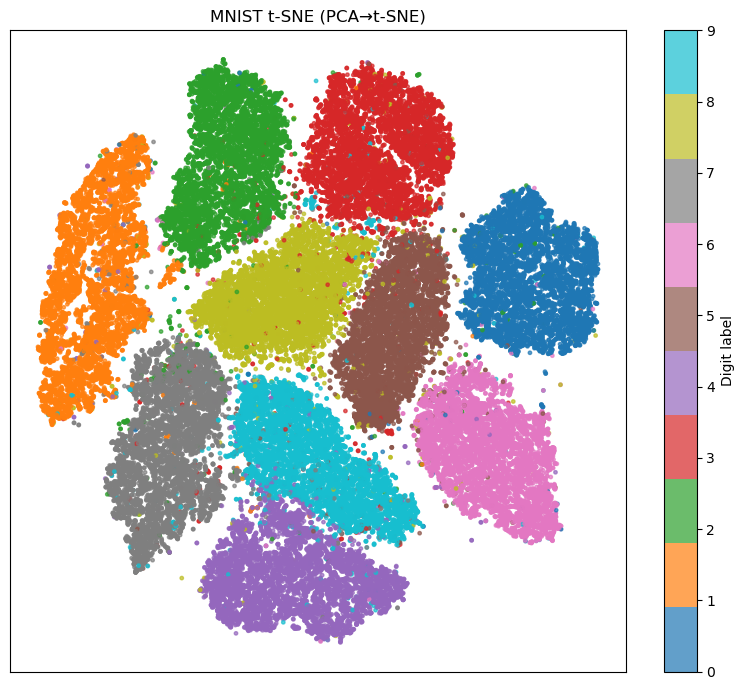

In [ ]:

# ----- config -----
save_path = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist"  # set your folder
batch_size = 1024
subset_n = None   # set None to use all (slow); 10k is a good default
pca_dim = 50
perplexity = 30
random_state = 0

# ----- load MNIST (no saving needed beyond the cache in save_path) -----
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root=save_path, train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root=save_path, train=False, download=True, transform=transform)

# concatenate train and test sets
full_ds = torch.utils.data.ConcatDataset([train_ds, test_ds])
full_ds.targets = np.concatenate([train_ds.targets.numpy(), test_ds.targets.numpy()])

train_len = len(train_ds)
test_len = len(test_ds)

# optional: take a balanced subset for speed
if subset_n is not None and subset_n < len(full_ds):
    # stratified by label
    idxs = []
    per_class = subset_n // 10
    targets = np.array(full_ds.targets)
    for c in range(10):
        cls_idx = np.where(targets == c)[0]
        np.random.default_rng(random_state).shuffle(cls_idx)
        idxs.extend(cls_idx[:per_class])
    full_ds = Subset(full_ds, idxs)

loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# ----- stack images and labels -----
Xs, ys = [], []
for x, y in loader:
    # x: [B,1,28,28] -> flatten to [B, 784]
    Xs.append(x.view(x.size(0), -1).numpy())
    ys.append(y.numpy())
X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0)

# ----- PCA (helps t-SNE speed/stability) -----
X_pca = PCA(n_components=pca_dim, random_state=random_state).fit_transform(X)

# ----- t-SNE to 2D -----
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    init="pca",
    n_iter=1000,
    random_state=random_state,
    verbose=1,
)
X_2d = tsne.fit_transform(X_pca)

# ----- plot -----
plt.figure(figsize=(8, 7))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=6, alpha=0.7, cmap="tab10")
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Digit label")
plt.title("MNIST t-SNE (PCA→t-SNE)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

# ----- save -----
save_dict = {"train_tsne": X_2d[:train_len],
             "test_tsne": X_2d[train_len:],
             "train_labels": y[:train_len],
             "test_labels": y[train_len:]}

torch.save(save_dict, os.path.join(save_path, "mnist_tsne.pth"))

## pca

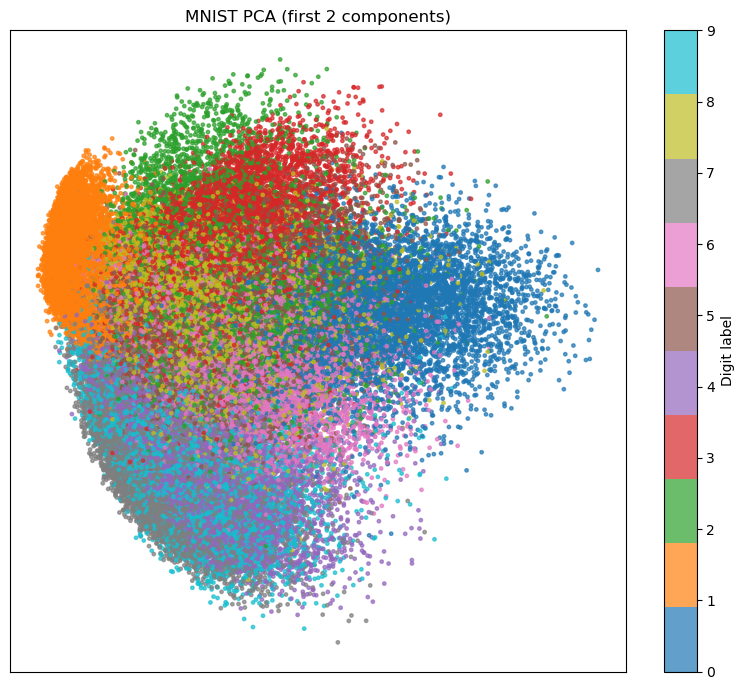

In [7]:
# ----- plot pca 2 first components -----
X_pca_2 = PCA(n_components=2, random_state=random_state).fit_transform(X)
plt.figure(figsize=(8, 7))
scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y, s=6, alpha=0.7, cmap="tab10")
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Digit label")
plt.title("MNIST PCA (first 2 components)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

## load tsne embeddings

In [ ]:
save_dict = torch.load(os.path.join(save_path, "mnist_tsne.pth"),weights_only=False)
print("Saved keys:", save_dict.keys())
print([item.shape for item in save_dict.values()])

Saved keys: dict_keys(['train_tsne', 'test_tsne', 'train_labels', 'test_labels', 'probs_train', 'probs_test', 'prob_map', 'x_vec', 'y_vec'])
[torch.Size([60000, 2]), torch.Size([10000, 2]), torch.Size([60000]), torch.Size([10000]), torch.Size([60000, 10]), torch.Size([10000, 10]), torch.Size([256, 256, 10]), torch.Size([256]), torch.Size([256])]
train_tsne: <class 'torch.Tensor'>
test_tsne: <class 'torch.Tensor'>
train_labels: <class 'torch.Tensor'>
test_labels: <class 'torch.Tensor'>
probs_train: <class 'torch.Tensor'>
probs_test: <class 'torch.Tensor'>
prob_map: <class 'torch.Tensor'>
x_vec: <class 'torch.Tensor'>
y_vec: <class 'torch.Tensor'>


In [62]:

include_test = False

X = np.concatenate([save_dict["train_tsne"], save_dict["test_tsne"]], axis=0)
y = np.concatenate([save_dict["train_labels"], save_dict["test_labels"]], axis=0)
if include_test:
    prob_map, summed_density, x_vec, y_vec = mu.class_density_map(X,y, std_mult=0.1, max_sidelength=256, truncate=3, square=True)
else:
    prob_map, summed_density, x_vec, y_vec = mu.class_density_map(save_dict["train_tsne"],save_dict["train_labels"], std_mult=0.1, max_sidelength=256, truncate=3, square=True)
probs = mu.get_tsne_probs(X, prob_map, x_vec, y_vec)
correct = (probs.argmax(axis=1) == y)
n_train = len(save_dict["train_labels"])
train_acc = correct[:n_train].mean()
test_acc = correct[n_train:].mean()
print(f"t-SNE 2D class-probability accuracy: train {train_acc*100:.2f}%, test {test_acc*100:.2f}%, overall {correct.mean()*100:.2f}%")

Building density map:   0%|                           | 0/60000 [00:00<?, ?it/s]

t-SNE 2D class-probability accuracy: train 97.34%, test 97.39%, overall 97.34%


In [65]:
#----- save probs -----
#save_dict["probs_train"] = probs[:n_train]
#save_dict["probs_test"] = probs[n_train:]
save_dict["prob_map"] = prob_map
save_dict["x_vec"] = x_vec
save_dict["y_vec"] = y_vec
torch.save(save_dict, os.path.join(save_path, "mnist_tsne.pth"))

In [82]:
prob_map.shape
alpha = 0.05
prob_map -= alpha
prob_map = np.clip(prob_map, 0.0, None)
prob_map /= (prob_map.sum(axis=-1, keepdims=True)+1e-12)

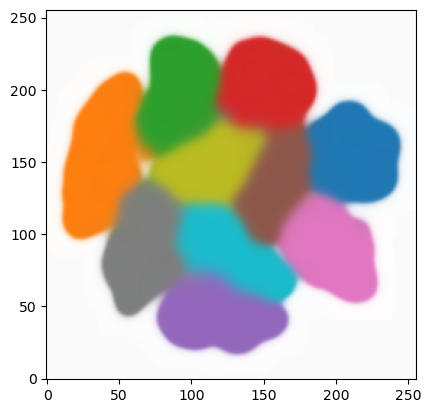

In [102]:
tab10_colors = plt.get_cmap("tab10").colors

rgb_map = np.zeros((prob_map.shape[0], prob_map.shape[1], 3), dtype=np.float64)
for c in range(10):
    rgb_map += prob_map[:, :, c:c+1] * np.array(tab10_colors[c])[None, None, :]
white_mask = 1/(1+np.exp(38*summed_density[...,None]/summed_density[...,None].max()-4))
rgb_map = np.array([1.0, 1.0, 1.0]) * white_mask + (1-white_mask) * rgb_map
rgb_map = np.clip(rgb_map, 0.0, 1.0)
plt.imshow(rgb_map, origin='lower')

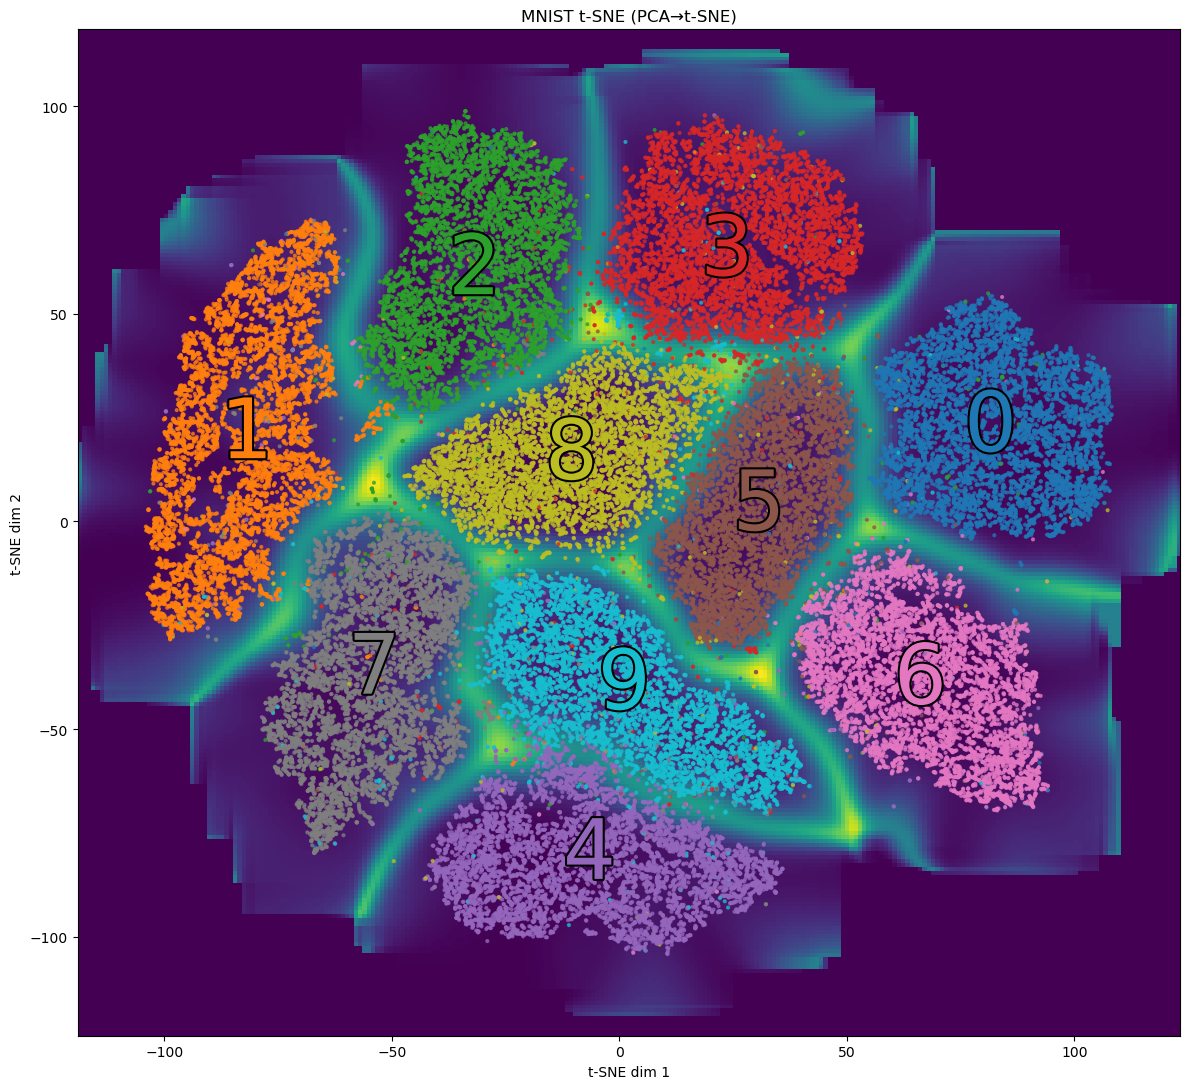

In [67]:
import matplotlib.patheffects as patheffects

entropy_map = np.sum(-prob_map * np.log(prob_map + 1e-12), axis=2).reshape(summed_density.shape)
plt.figure(figsize=(12,11))
#plt.imshow(rgb_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=0.6, cmap="gray")
plt.imshow(entropy_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=1.0, cmap="viridis")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=4, alpha=0.7, cmap="tab10")
plt.title("MNIST t-SNE (PCA→t-SNE)")
for i in range(10):
    digit_mask = (y == i)
    x_mean = X[digit_mask, 0].mean()
    y_mean = X[digit_mask, 1].mean()
    plt.text(x_mean, y_mean, str(i), fontsize=60, fontweight='light',
             color=f'C{i}', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=3, foreground='black')])
plt.tight_layout()
plt.show()


Accuracy excluding lowest 10.0% confidence: 98.49%
Accuracy excluding highest 10.0% entropy: 97.07%


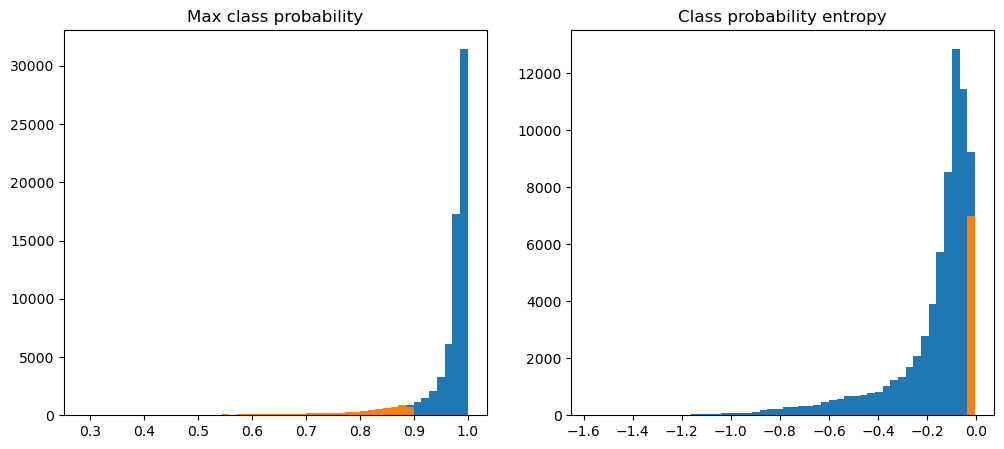

In [59]:
max_prob = probs.max(axis=1)
entropy = np.sum(probs * np.log(np.clip(probs, 1e-12, None)), axis=1)

pred = probs.argmax(axis=1)
reject = 0.1

plt.subplots(1,2,figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Max class probability")
h = plt.hist(max_prob, bins=50)
mask = max_prob < np.quantile(max_prob, reject)
plt.hist(max_prob[mask], bins=h[1])
acc_without_lowconf = (pred == y)[~mask].mean()
print(f"Accuracy excluding lowest {100*reject}% confidence: {acc_without_lowconf*100:.2f}%")
plt.subplot(1,2,2)
plt.title("Class probability entropy")
h = plt.hist(entropy, bins=50)
mask = entropy > np.quantile(entropy, 1 - reject)
plt.hist(entropy[mask], bins=h[1])
acc_without_highent = (pred == y)[~mask].mean()
print(f"Accuracy excluding highest {100*reject}% entropy: {acc_without_highent*100:.2f}%")
plt.show()

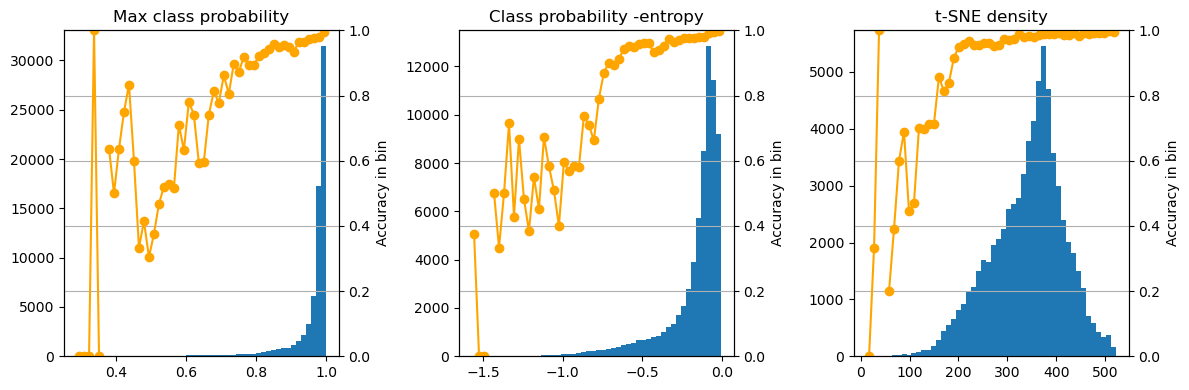

In [60]:
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Max class probability")
h = plt.hist(max_prob, bins=50)
bin_accs = {}
bin_acc = []
for b1,b2 in zip(h[1][:-1], h[1][1:]):
    mask = (max_prob >= b1) & (max_prob < b2)
    if np.sum(mask) > 0:
        bin_acc.append((pred[mask] == y[mask]).mean())
    else:
        bin_acc.append(np.nan)
bin_centers = (h[1][:-1] + h[1][1:]) * 0.5
bin_accs["max_prob"] = (bin_centers,bin_acc)
#plot [0,1] y axis on the left for bin_acc
plt.twinx()
plt.plot((h[1][:-1] + h[1][1:]) * 0.5, bin_acc, '-o', color='orange')
plt.ylim(0, 1)
plt.ylabel("Accuracy in bin")
plt.xlabel("Max class probability")
plt.grid()
plt.subplot(1,3,2)
plt.title("Class probability -entropy")
h = plt.hist(entropy, bins=50)
bin_acc = []
for b1,b2 in zip(h[1][:-1], h[1][1:]):
    mask = (entropy >= b1) & (entropy < b2)
    if np.sum(mask) > 0:
        bin_acc.append((pred[mask] == y[mask]).mean())
    else:
        bin_acc.append(np.nan)
bin_centers = (h[1][:-1] + h[1][1:]) * 0.5
bin_accs["entropy"] = (bin_centers,bin_acc)
#plot [0,1] y axis on the left for bin_acc
plt.twinx()
plt.plot((h[1][:-1] + h[1][1:]) * 0.5, bin_acc, '-o', color='orange')
plt.ylim(0, 1)
plt.ylabel("Accuracy in bin")
plt.xlabel("Class probability entropy")
plt.grid()
plt.subplot(1,3,3)
density = mu.get_tsne_probs(X, summed_density[...,None], x_vec, y_vec).flatten()
plt.title("t-SNE density")
h = plt.hist(density, bins=50)
bin_acc = []
for b1,b2 in zip(h[1][:-1], h[1][1:]):
    mask = (density >= b1) & (density < b2)
    if np.sum(mask) > 0:
        bin_acc.append((pred[mask] == y[mask]).mean())
    else:
        bin_acc.append(np.nan)
bin_centers = (h[1][:-1] + h[1][1:]) * 0.5
bin_accs["density"] = (bin_centers,bin_acc)
#plot [0,1] y axis on the left for bin_acc
plt.twinx()
plt.plot((h[1][:-1] + h[1][1:]) * 0.5, bin_acc, '-o', color='orange')
plt.ylim(0, 1)
plt.ylabel("Accuracy in bin")
plt.xlabel("t-SNE density")
plt.grid()

plt.tight_layout()
plt.show()

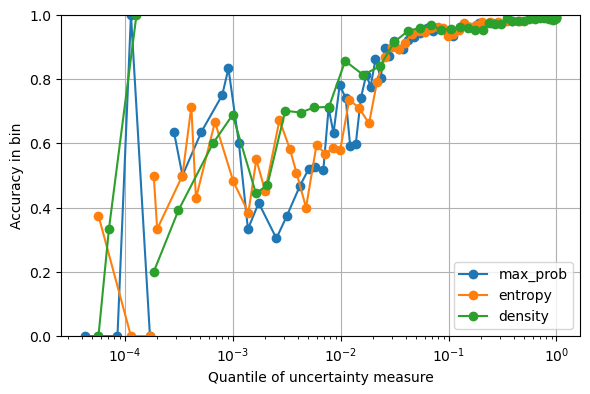

In [62]:
#quantile vs bin probability plot for the 3 methods

plt.figure(figsize=(6,4))

def quantile_inverse(x,vals):
    #returns the quantile for each value in vals
    return np.array([np.mean(x <= v) for v in vals])
methods = ["max_prob", "entropy", "density"]
quantiles = {"max_prob": quantile_inverse(max_prob, bin_accs["max_prob"][0]),
             "entropy": quantile_inverse(entropy, bin_accs["entropy"][0]),
             "density": quantile_inverse(density, bin_accs["density"][0])}
for m in methods:
    plt.plot(quantiles[m], bin_accs[m][1], '-o', label=m)
plt.ylim(0, 1)
plt.ylabel("Accuracy in bin")
plt.xlabel("Quantile of uncertainty measure")
plt.grid()
plt.legend()
plt.tight_layout()
plt.xscale('log')
plt.show()

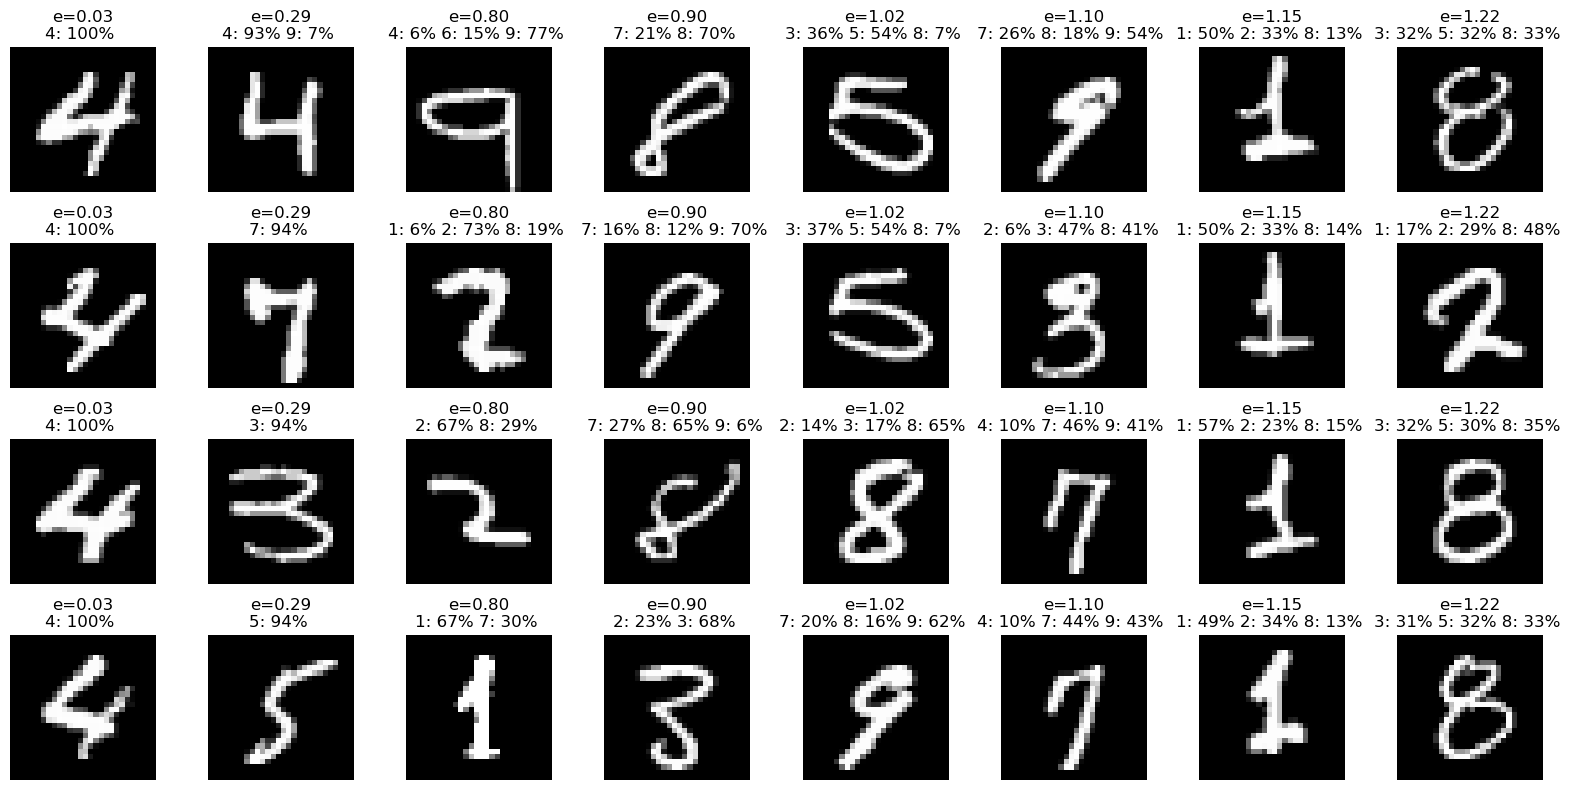

In [104]:
#Qualitative inspection. Plot images for a specific entropy quantiles and show them with their >5% probs
prob_show = 0.05
entropy_quantiles = [0, 0.5, 0.9, 0.95, 0.98, 0.99, 0.995, 0.999]
n_per_quantile = 4


indices = -np.ones((n_per_quantile, len(entropy_quantiles)), dtype=np.int64)
#finds nearest to quantile level
for q_idx, q in enumerate(entropy_quantiles):
    target_entropy = np.quantile(entropy, q)
    sorted_idx = np.argsort(np.abs(entropy - target_entropy))
    found = 0
    for si in sorted_idx:
        if probs[si, pred[si]] >= prob_show:
            indices[found, q_idx] = si
            found += 1
            if found >= n_per_quantile:
                break

fig, axs = plt.subplots(n_per_quantile, len(entropy_quantiles), figsize=(2*len(entropy_quantiles), 2*n_per_quantile))
for i in range(n_per_quantile):
    for j in range(len(entropy_quantiles)):
        ax = axs[i, j] if n_per_quantile > 1 else axs[j]
        idx = indices[i, j]
        if idx < 0:
            ax.axis('off')
            continue
        img = X_images[idx].reshape(28, 28)
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        title = f"e={entropy[idx]:.2f}\n"
        for c in range(10):
            if probs[idx, c] >= prob_show:
                title += f"{c}: {int(np.round(probs[idx,c]*100)):d}% "
        ax.set_title(title)
        ax.axis('off')
plt.tight_layout()
plt.show()

 

## voronoi

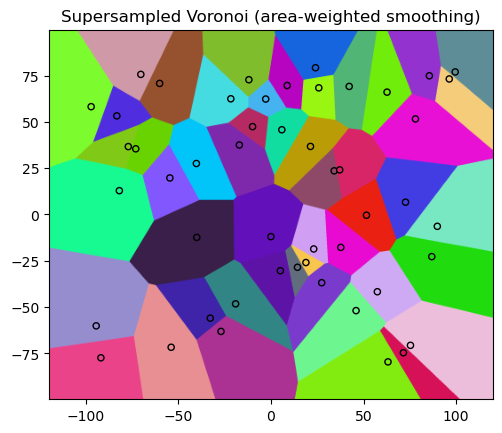

In [74]:
# example data
rng = np.random.default_rng(0)
pts = rng.uniform([-100, -80], [100, 80], size=(50, 2))
vals = rng.uniform(0, 1, size=(50,3))   # scalar values; or use (50,C) for vector

img, x_vec, y_vec = voronoi_raster(
    points=pts, values=vals,
    xlim=(-120, 120), ylim=(-100, 100),
    size=(400, 500), supersample=4
)

# plot
import matplotlib.pyplot as plt
plt.imshow(img, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]),
           origin='lower', aspect='equal', cmap='viridis')
plt.scatter(pts[:,0], pts[:,1], c=vals, edgecolor='k', s=20)
plt.title("Supersampled Voronoi (area-weighted smoothing)")
plt.show()


## train mnist

In [4]:
train_dl, val_dl = mu.get_dataloaders(ignore_digits=[2,3,5], augment=False, batch_size=32, interpolation_factor=1.0, ambiguous_vae_samples=False)
print(f"Train size: {len(train_dl.dataset)}, Val size: {len(val_dl.dataset)}")
batch = next(iter(train_dl))
print(f"Batch shapes: {[b.shape for b in batch]}")  # (B,1,28,28), (B,), (B,2), (B,10)

Train size: 42490, Val size: 7066
Batch shapes: [torch.Size([32, 1, 28, 28]), torch.Size([32, 2]), torch.Size([32, 10])]


In [4]:
model = mu.get_models_dict(tsne=0)["CNN1"]()
print("Training model with ", model.num_params(), "parameters")
train_dl, val_dl = mu.get_dataloaders(ignore_digits=[2,3,5], augment=False, batch_size=256, ambiguous_vae_samples=1)
history = mu.train(model, train_dl, val_dl, epochs=20, lr=1e-4, weight_decay=0.0, cosine_anneal_epochs=20, au_factor=0.0, soft_labels=True)

Training model with  255128 parameters


Training:   0%|          | 0/4480 [00:00<?, ?it/s]

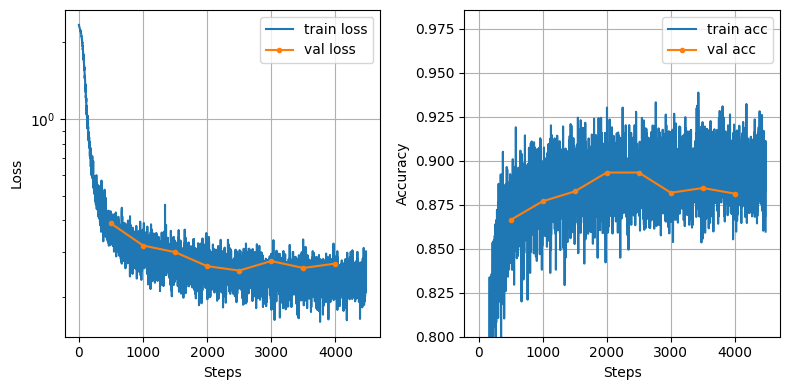

In [5]:
mu.loss_plot(history)

In [6]:
#train_dl, val_dl = mu.get_dataloaders(shuffle_train=False)
train_dl, val_dl = mu.get_dataloaders(ignore_digits=[2,3,5], augment=False, batch_size=256, ambiguous_vae_samples=1, shuffle_train=False)
train_probs, val_probs = mu.model_probs_on_all_points(model, [train_dl, val_dl])
model_probs = np.concatenate([train_probs.numpy(), val_probs.numpy()], axis=0)
save_dict = torch.load(os.path.join(save_path, "mnist_tsne.pth"),weights_only=False)

train_acc = (train_dl.dataset.probs[torch.arange(len(train_dl.dataset)),train_probs.argmax(axis=1)]).mean()
test_acc = (val_dl.dataset.probs[torch.arange(len(val_dl.dataset)),val_probs.argmax(axis=1)]).mean()
print(f"Training acc: {train_acc*100:.2f}%, test acc: {test_acc*100:.2f}%")

Training acc: 89.38%, test acc: 88.95%


## train plotting

Building density map:  12%|█▌           | 7000/60000 [00:00<00:00, 69993.22it/s]

t-SNE 2D class-probability accuracy: train 97.34%, test 97.39%, overall 97.34%


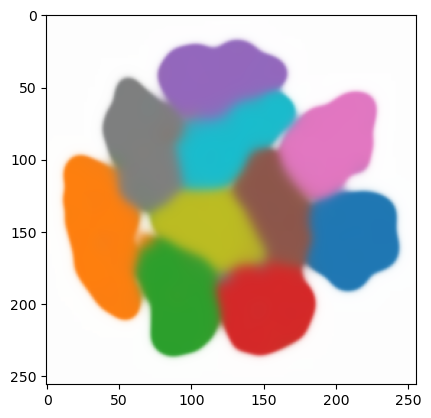

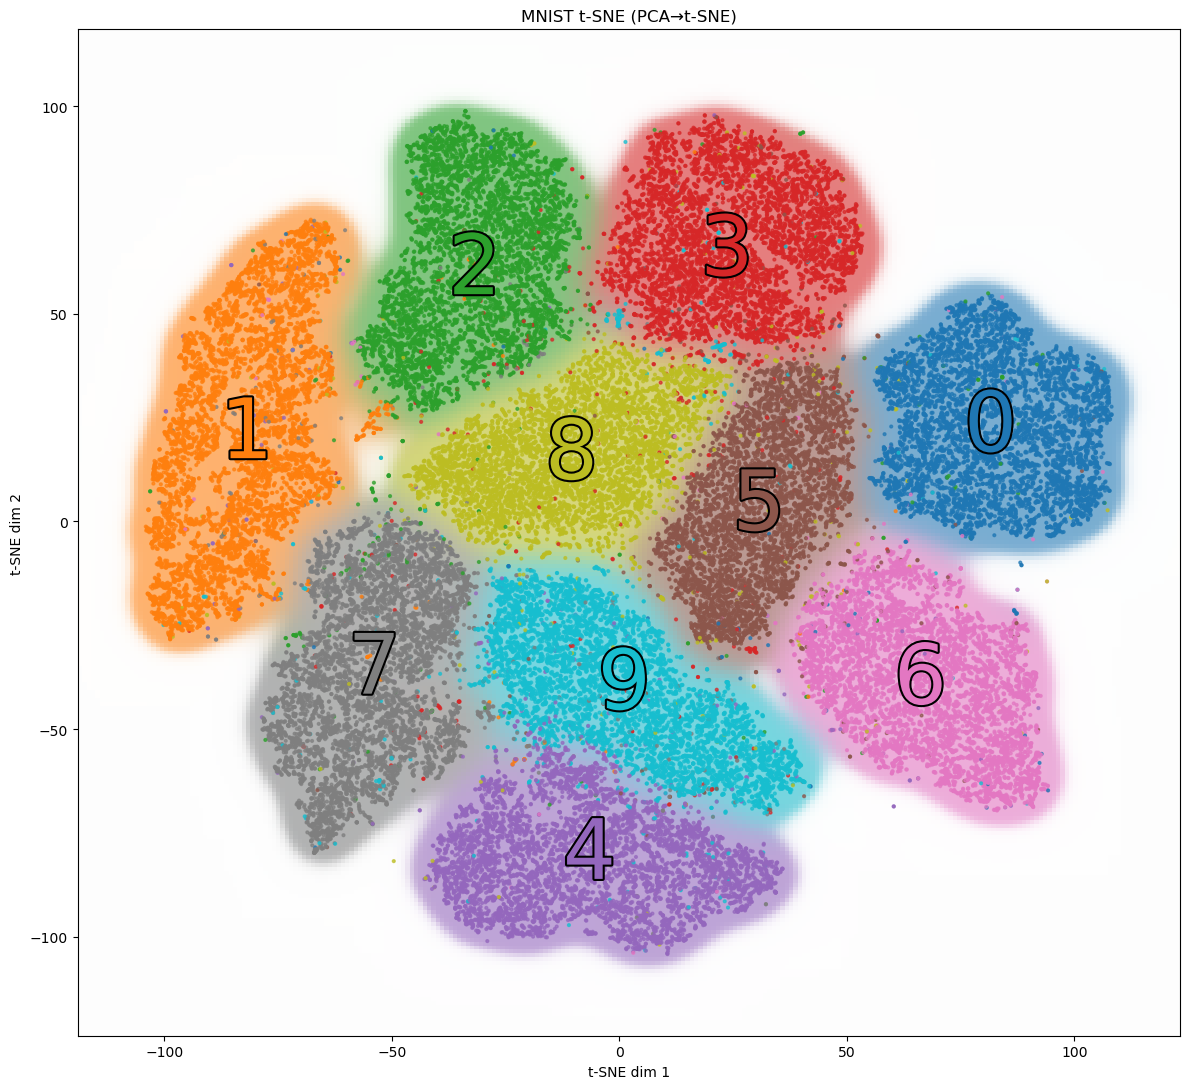

In [9]:
import matplotlib.patheffects as patheffects
tab10_colors = plt.get_cmap("tab10").colors

include_test = False

X = np.concatenate([save_dict["train_tsne"], save_dict["test_tsne"]], axis=0)
y = np.concatenate([save_dict["train_labels"], save_dict["test_labels"]], axis=0)
if include_test:
    prob_map, summed_density, x_vec, y_vec = mu.class_density_map(X,y, std_mult=0.1, max_sidelength=256, truncate=3, square=True)
else:
    prob_map, summed_density, x_vec, y_vec = mu.class_density_map(save_dict["train_tsne"],save_dict["train_labels"], std_mult=0.1, max_sidelength=256, truncate=3, square=True)
xvec0, xvec1 = x_vec[0], x_vec[-1]
yvec0, yvec1 = y_vec[0], y_vec[-1]
probs = mu.get_tsne_probs(X, prob_map, x_vec, y_vec)
correct = (probs.argmax(axis=1) == y)
n_train = len(save_dict["train_labels"])
train_acc = correct[:n_train].mean()
test_acc = correct[n_train:].mean()
print(f"t-SNE 2D class-probability accuracy: train {train_acc*100:.2f}%, test {test_acc*100:.2f}%, overall {correct.mean()*100:.2f}%")
rgb_map = np.zeros((prob_map.shape[0], prob_map.shape[1], 3), dtype=np.float64)
for c in range(10):
    rgb_map += prob_map[:, :, c:c+1] * np.array(tab10_colors[c])[None, None, :]
white_mask = 1/(1+np.exp(38*summed_density[...,None]/summed_density[...,None].max()-5))
rgb_map = np.array([1.0, 1.0, 1.0]) * white_mask + (1-white_mask) * rgb_map
rgb_map = np.clip(rgb_map, 0.0, 1.0)
plt.imshow(rgb_map)
#entropy_map = np.sum(-prob_map * np.log(prob_map + 1e-12), axis=2).reshape(summed_density.shape)
plt.figure(figsize=(12,11))
plt.imshow(rgb_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=0.6, cmap="gray")
#plt.imshow(entropy_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=1.0, cmap="viridis")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=4, alpha=0.7, cmap="tab10")
plt.title("MNIST t-SNE (PCA→t-SNE)")
for i in range(10):
    digit_mask = (y == i)
    x_mean = X[digit_mask, 0].mean()
    y_mean = X[digit_mask, 1].mean()
    plt.text(x_mean, y_mean, str(i), fontsize=60, fontweight='light',
             color=f'C{i}', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=3, foreground='black')])
plt.tight_layout()
plt.show()


Text(0, 0.5, 't-SNE dim 2')

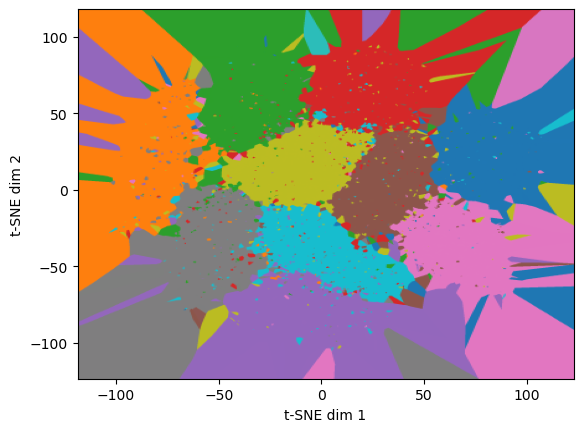

In [10]:
points = np.concatenate([save_dict["train_tsne"], save_dict["test_tsne"]], axis=0)
voronoi,x_vec,y_vec = mu.voronoi_raster(points, model_probs, (xvec0, xvec1), (yvec0, yvec1), (400,400), supersample=4)

voronoi_rgb = np.zeros((voronoi.shape[0], voronoi.shape[1], 3), dtype=np.float64)
for c in range(10):
    voronoi_rgb += voronoi[:, :, c:c+1] * np.array(tab10_colors[c])[None, None, :]

voronoi_entropy = np.sum(-voronoi * np.log(voronoi + 1e-12), axis=2).reshape(voronoi.shape[0], voronoi.shape[1])
plt.imshow(voronoi_rgb,extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=1.0)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")

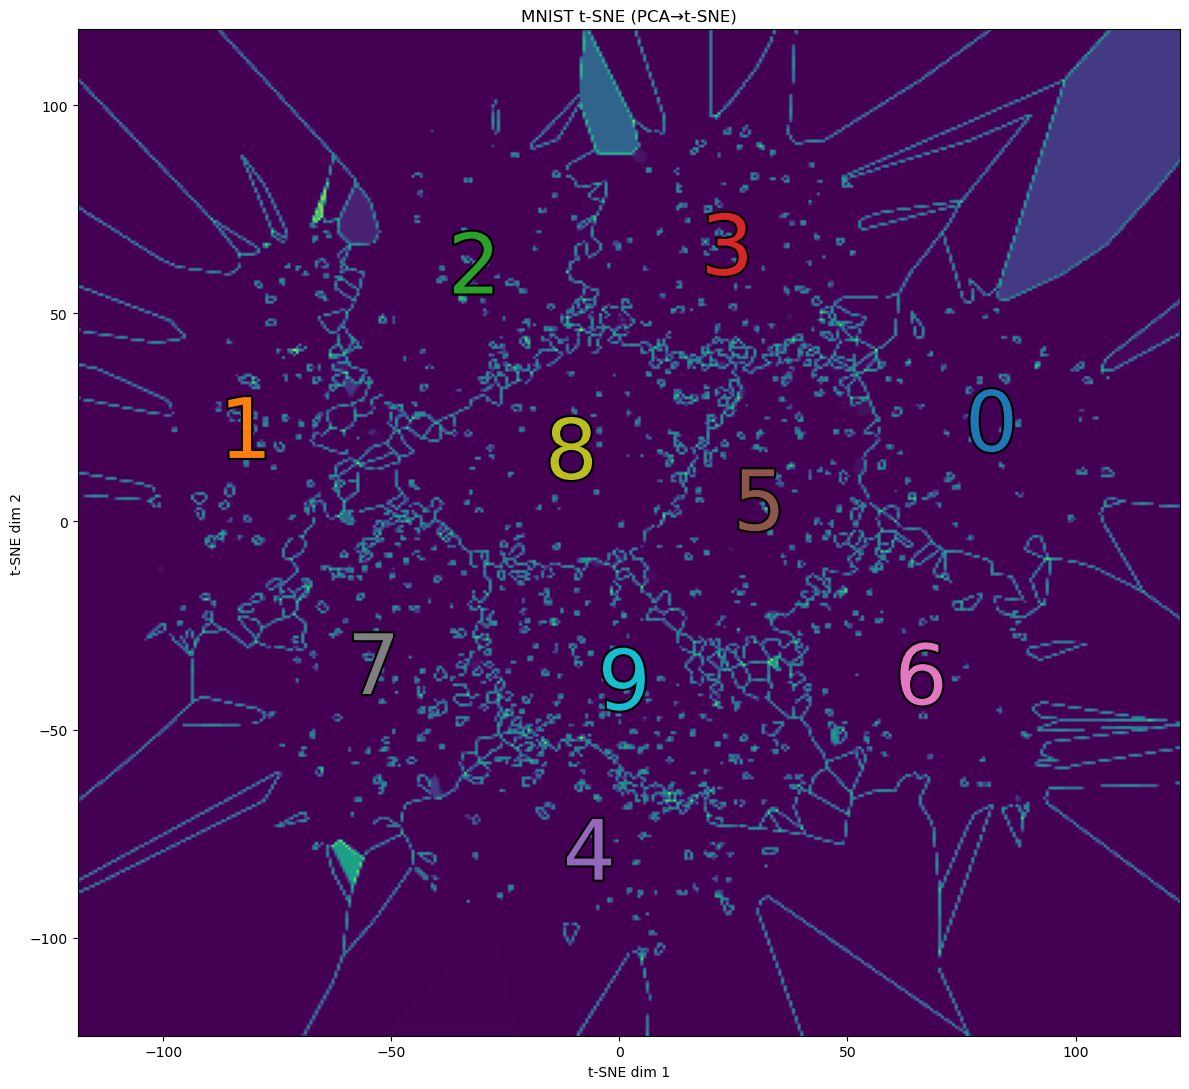

In [11]:
plt.figure(figsize=(12,11))
#plt.imshow(voronoi_rgb,extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=0.6)
plt.imshow(voronoi_entropy,extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=1.0)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
#scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=4, alpha=0.7, cmap="tab10")
plt.title("MNIST t-SNE (PCA→t-SNE)")
for i in range(10):
    digit_mask = (y == i)
    x_mean = X[digit_mask, 0].mean()
    y_mean = X[digit_mask, 1].mean()
    plt.text(x_mean, y_mean, str(i), fontsize=60, fontweight='light',
             color=f'C{i}', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=3, foreground='black')])
plt.tight_layout()
plt.show()

## inspect big training results

In [3]:
import pandas as pd
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves"

df = pd.DataFrame(columns=["uncertainty","model","train_acc","test_acc","params"])

for filename in os.listdir(p):
    if filename.endswith(".pth"):
        file_path = os.path.join(p, filename)
        data = torch.load(file_path, weights_only=False)
        num_params = sum([v.numel() for v in data["checkpoints"][0].values()])
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        n = len(data["checkpoints"])
        for i in range(n):
            values = [unc_cfg,model_cfg, 
                      float(data["final_acc"][i]["train_acc"]), 
                      float(data["final_acc"][i]["test_acc"]), 
                      num_params]
            df.loc[len(df)] = values
print(f"Found {len(df)} models")

Found 1180 models


In [4]:
degenerate = df["train_acc"] < 0.8
uq_unc_cfgs = df["uncertainty"].unique().tolist()
uq_model_cfgs = df["model"].unique().tolist()
#print all unique uncertainty types and X/N degerates
for u in uq_unc_cfgs:
    n_total = len(df[df["uncertainty"]==u])
    n_degen = len(df[(df["uncertainty"]==u) & degenerate])
    print(f"Uncertainty: {u}, total: {n_total}, degenerate: {n_degen} ({n_degen/n_total*100:.1f}%)")
for m in uq_model_cfgs:
    n_total = len(df[df["model"]==m])
    n_degen = len(df[(df["model"]==m) & degenerate])
    print(f"Model: {m}, total: {n_total}, degenerate: {n_degen} ({n_degen/n_total*100:.1f}%)")

Uncertainty: AU2_soft, total: 70, degenerate: 10 (14.3%)
Uncertainty: AU2_EU_soft, total: 70, degenerate: 0 (0.0%)
Uncertainty: AU.3, total: 90, degenerate: 0 (0.0%)
Uncertainty: AU_EU_soft, total: 70, degenerate: 0 (0.0%)
Uncertainty: AU2_EU, total: 360, degenerate: 0 (0.0%)
Uncertainty: AU_EU, total: 90, degenerate: 0 (0.0%)
Uncertainty: AU, total: 90, degenerate: 0 (0.0%)
Uncertainty: AU.3_EU, total: 90, degenerate: 0 (0.0%)
Uncertainty: AU2, total: 70, degenerate: 10 (14.3%)
Uncertainty: EU, total: 90, degenerate: 0 (0.0%)
Uncertainty: NoUnc, total: 90, degenerate: 0 (0.0%)
Model: overfitted_MLP, total: 110, degenerate: 0 (0.0%)
Model: underfitted_MLP, total: 110, degenerate: 0 (0.0%)
Model: well_fitted_MLP, total: 110, degenerate: 0 (0.0%)
Model: overfitted_CNN, total: 110, degenerate: 0 (0.0%)
Model: MLP_c64_aug0, total: 10, degenerate: 0 (0.0%)
Model: well_fitted_tsne_MLP, total: 110, degenerate: 20 (18.2%)
Model: CNN_d8_aug0, total: 10, degenerate: 0 (0.0%)
Model: uberfitted_CN

In [5]:
print(uq_model_cfgs)
print(uq_unc_cfgs)

['overfitted_MLP', 'underfitted_MLP', 'well_fitted_MLP', 'overfitted_CNN', 'MLP_c64_aug0', 'well_fitted_tsne_MLP', 'CNN_d8_aug0', 'uberfitted_CNN', 'MLP_c512_aug0', 'well_fitted_CNN', 'CNN_c8_aug1', 'CNN_c32_aug0', 'CNN_d4_aug1', 'CNN_c4_aug1', 'CNN_d2_aug1', 'CNN_c32_aug1', 'CNN_c64_aug0', 'CNN_d1_aug1', 'underfitted_CNN', 'MLP_c128_aug1', 'uberfitted_MLP', 'CNN_d2_aug0', 'MLP_c256_aug1', 'CNN_c16_aug0', 'CNN_d4_aug0', 'MLP_c256_aug0', 'MLP_c512_aug1', 'MLP_c64_aug1', 'CNN_c8_aug0', 'MLP_c128_aug0', 'CNN_c4_aug0', 'CNN_d1_aug0', 'MLP_c32_aug1', 'CNN_c16_aug1', 'MLP_c32_aug0', 'CNN_c64_aug1']
['AU2_soft', 'AU2_EU_soft', 'AU.3', 'AU_EU_soft', 'AU2_EU', 'AU_EU', 'AU', 'AU.3_EU', 'AU2', 'EU', 'NoUnc']


In [ ]:
use_unc_cfgs = ['AU2_soft', 'AU2_EU_soft', 'AU2', 'AU2_EU']
df = df[df["uncertainty"].isin(use_unc_cfgs)]

Using 270 models after filtering


In [8]:
uq_unc_cfgs = sorted(df["uncertainty"].unique().tolist())
uq_model_cfgs = sorted(df["model"].unique().tolist())

show_means = False
#cols = [f"C{i}" for i in range(len(uq_unc_cfgs))]
#symbols = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>'][:len(uq_model_cfgs)]
#symbols = ['H', '^', "P","X", 'o', 'v', 's', 'D', '*']
symbols = ['H', '^', 'o', 'v', 's', 'D', '*']
cols = ["C3", "C1", "C2", "C4", "C0", "C5"]
assert len(cols) >= len(uq_unc_cfgs), f"Only {len(cols)} colors for {len(uq_unc_cfgs)} uncertainty types"
assert len(symbols) >= len(uq_model_cfgs), f"Only {len(symbols)} symbols for {len(uq_model_cfgs)} model types"
plt.figure(figsize=(10,6))
for i,unc in enumerate(uq_unc_cfgs):
    for j,model in enumerate(uq_model_cfgs):
        mask = (df["uncertainty"] == unc) & (df["model"] == model) & (df["train_acc"] > 0.5)
        if np.sum(mask) == 0:
            continue
        if show_means:
            
            mean_point = df.loc[mask, ["train_acc", "test_acc"]].mean(axis=0)
            plt.scatter(mean_point["train_acc"], mean_point["test_acc"],
                    color=cols[i], marker=symbols[j], s=300, alpha=1.0, edgecolor='k', linewidth=2)

        
        plt.scatter(df.loc[mask, "train_acc"], df.loc[mask, "test_acc"],
                color=cols[i], marker=symbols[j], s=100, alpha=0.0 if show_means else 0.7, edgecolor='k')
for j,model in enumerate(uq_model_cfgs):
    plt.scatter([], [], color='k', marker=symbols[j], s=100, label=model)
for i,unc in enumerate(uq_unc_cfgs):
    plt.scatter([], [], color=cols[i], marker='o', s=100, label=unc)
plt.xlabel("Training accuracy")
plt.ylabel("Test accuracy")
plt.legend(ncols=2)
#get current axis bounds
ax = plt.gca()
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
l1,l2 = min(x0,y0), max(x1,y1)
plt.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
plt.xlim(l1,l2), plt.ylim(l1,l2)
plt.grid()

cols = ["C3", "C1", "C6", "C4", "C0", "C5"]
symbols = ['H', '^', 'o', 'v', 's', 'D', '*']


AssertionError: Only 7 symbols for 27 model types

In [103]:
print(uq_unc_cfgs)
print(uq_model_cfgs)

['AU', 'AU.3', 'AU.3_EU', 'AU_EU', 'EU', 'NoUnc']
['overfitted_CNN', 'overfitted_MLP', 'underfitted_CNN', 'underfitted_MLP', 'well_fitted_CNN', 'well_fitted_MLP', 'well_fitted_tsne_MLP']


In [8]:
unc_cfg = "AU2_EU"
model_cfg = "underfitted_MLP"

data = torch.load(os.path.join(p, f"{unc_cfg}__{model_cfg}.pth"), weights_only=False)

out_dict = mu.uncertainty_stats_from_ckpts(data["checkpoints"], model_func=mu.model_func_from_ensemble_dict(data), include_train=False, T=1, add_stats=1)


Processing models:   0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
data = torch.load("/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves/AU2_EU__well_fitted_CNN.pth", weights_only=False)
out_dict = data["unc_stats"]

In [50]:
mask = out_dict["eval"]["probs_gts"][:,[2,3,5]].sum(1)< 1e-8

out_dict["ood_stats"] = mu.ood_stats(out_dict, do_plot=False)
out_dict["calib_stats"] = mu.calib_stats(out_dict,mask=mask, vae_mask=out_dict["eval"]["vae_mask"])
out_dict["amb_stats"] = mu.ambiguity_stats(out_dict, mask=mask, vae_mask=out_dict["eval"]["vae_mask"])

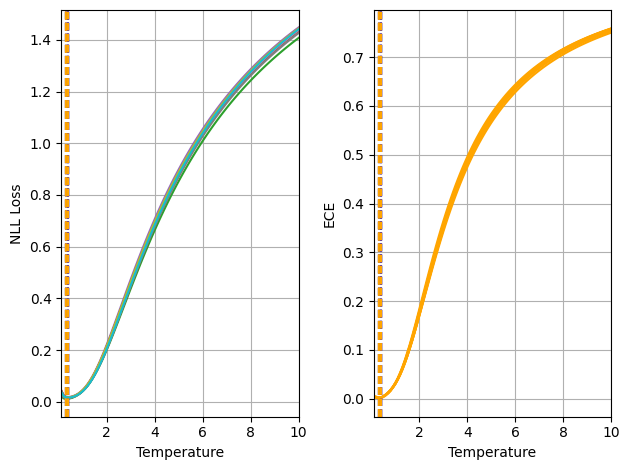

{'ece': 0.03771628882493257,
 'ece_optnll': 0.020352636493641323,
 'ece_optece': 0.021419972375799057,
 'nll': 0.1888834685087204,
 'nll_optnll': 0.18820595741271973,
 'nll_optece': 0.19072869420051575,
 'T_opt_nll': 0.4,
 'T_opt_ece': 0.35000000000000003,
 'ece_optece_eq': 0.039720621183976124,
 'ece_eq': 0.058114654811336375,
 'ece_optnll_eq': 0.06711486815961216,
 'ens_test_acc': 0.8938712477684021,
 'ens_test_acc_optece': 0.8941355347633362,
 'ens_test_acc_optnll': 0.8940196633338928}

In [49]:
mask = out_dict["eval"]["probs_gts"][:,[2,3,5]].sum(1)< 1e-8
mu.calib_stats(out_dict,mask=mask, vae_mask=out_dict["eval"]["vae_mask"], do_plot=True, is_AU2=True)

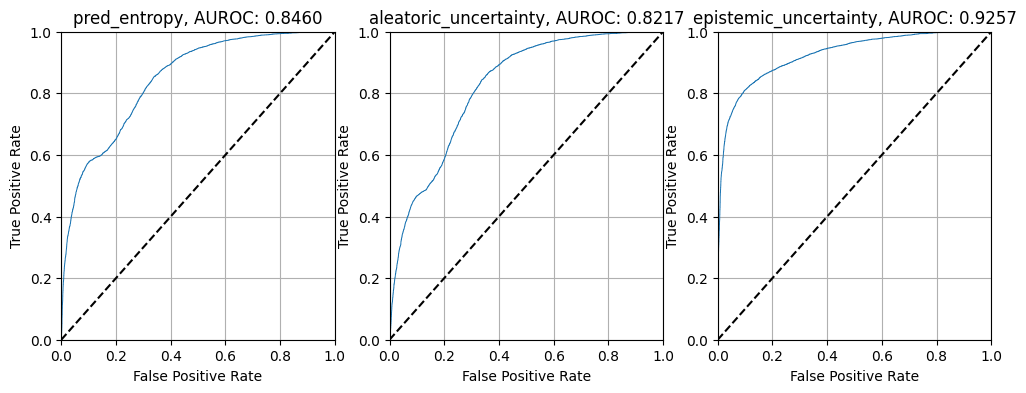

In [43]:
plt.figure(figsize=(12,4))
out_dict["ood_stats"] = mu.ood_stats(out_dict, do_plot=True)

In [ ]:
amb_stats = mu.ambiguity_stats(out_dict)

{'ece': 0.00510334047973156,
 'ece_optnll': 0.00510334047973156,
 'ece_optece': 0.00510334047973156,
 'nll': 0.039789718,
 'nll_optnll': 0.039789718,
 'nll_optece': 0.039789718,
 'T_opt_nll': 1.0,
 'T_opt_ece': 1.0}

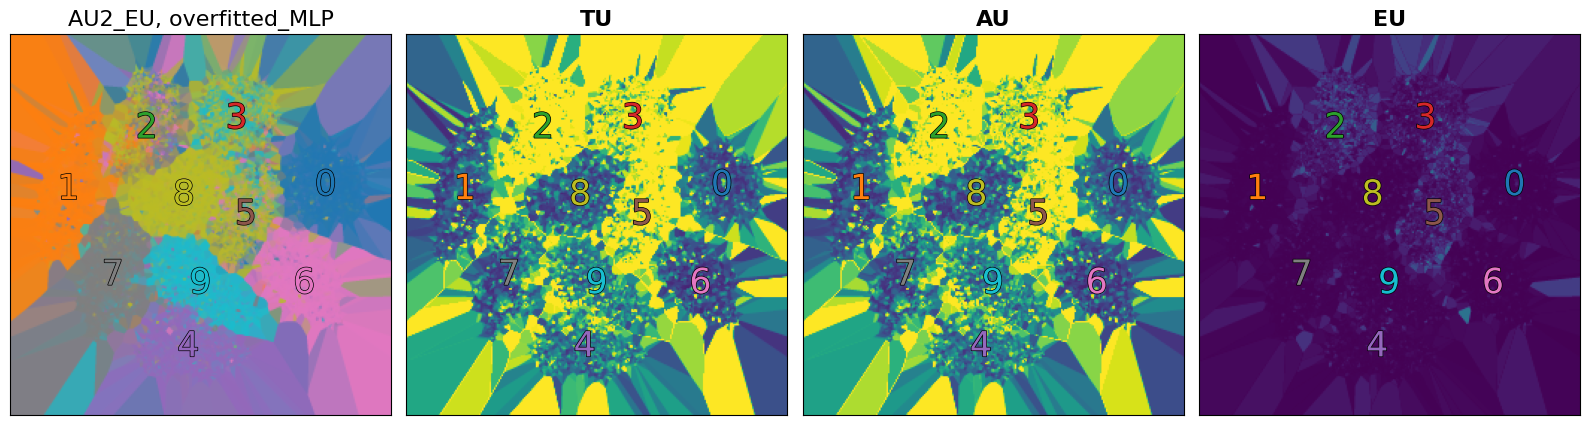

In [14]:
mu.plot_voronoi(out_dict, title=f"{unc_cfg}, {model_cfg}")

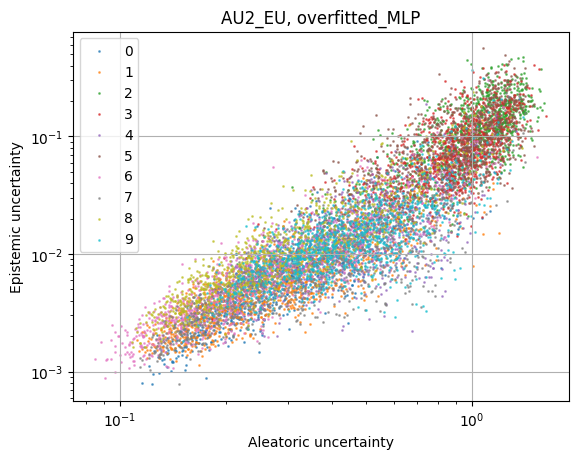

In [15]:
mask_235 = np.isin(out_dict["eval"]["gts"], [2,3,5])
#plt.scatter(out_dict["eval"]["unc"]["aleatoric_uncertainty"][~mask_235], out_dict["eval"]["unc"]["epistemic_uncertainty"][~mask_235], s=1, label="other", alpha=0.6)
for digit in range(10):
    mask = out_dict["eval"]["gts"] == digit
    plt.scatter(out_dict["eval"]["unc"]["aleatoric_uncertainty"][mask], out_dict["eval"]["unc"]["epistemic_uncertainty"][mask], s=1, label=str(digit), alpha=0.6)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Aleatoric uncertainty")
plt.ylabel("Epistemic uncertainty")
plt.title(f"{unc_cfg}, {model_cfg}")
plt.grid()

pred_entropy: entropy 2/3/5: 1.0434, not 2/3/5: 0.3951
aleatoric_uncertainty: entropy 2/3/5: 0.9404, not 2/3/5: 0.3816
epistemic_uncertainty: entropy 2/3/5: 0.1030, not 2/3/5: 0.0136


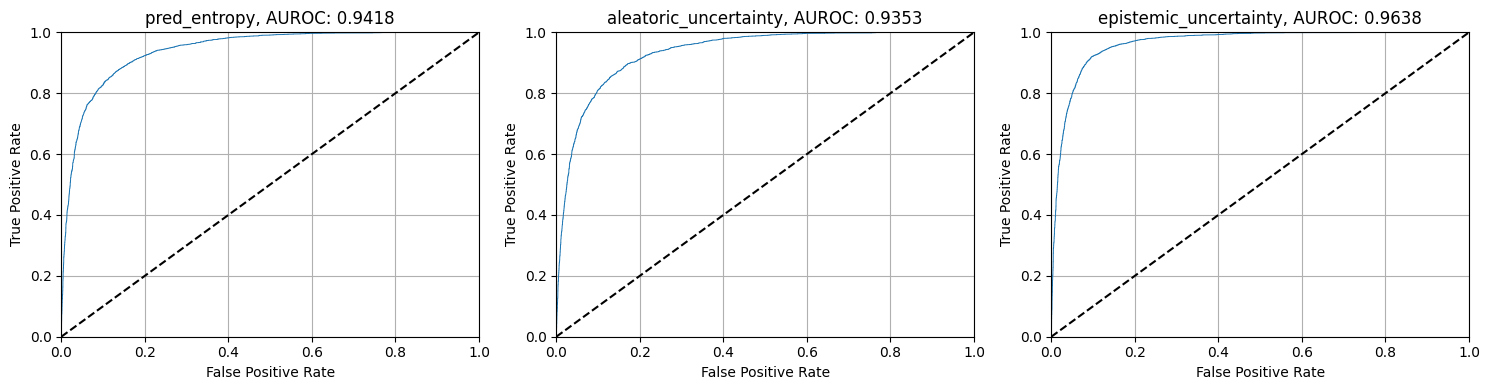

In [16]:
mask_235 = np.isin(out_dict["eval"]["gts"], [2,3,5])
unc_evals = {}
n = len(out_dict["eval"]["unc"])
plt.figure(figsize=(5*n,4))
for i,(k,v) in enumerate(out_dict["eval"]["unc"].items()):
    plt.subplot(1,n,i+1)
    auc, fpr, tpr, thresholds = mu.auroc(v, mask_235, do_plot=True)
    plt.title(f"{k}, AUROC: {auc:.4f}")
    entropy_235 = v[mask_235].mean()
    entropy_not235 = v[~mask_235].mean()
    print(f"{k}: entropy 2/3/5: {entropy_235:.4f}, not 2/3/5: {entropy_not235:.4f}")
    unc_evals[k] = {"auc": auc, "entropy_235": entropy_235, "entropy_not235": entropy_not235}
plt.tight_layout()
plt.show()

Tasks
1. **CALIB**: Calculate default ECE and temp-optimized ECE
2. **AM**: (For AU models) Dependent on problem type.
    1. If segmentation: Calculate per-label NCC maps between Unc and class pixel variance. Take mean over all iid samples.
    2. If classification: Look at rank correlation of 
3. **OOD**: (For EU models) Look at Unc for o.o.d detection for models with EU

For absolute uncertainty levels
1. **AM**: (For AU models) Calculate mean Unc on 10% highest gt entropy points and the exclusion
2. **OOD**: (For EU models) Calculate mean Unc on (2,3,5) and the exclusion


Model 0 T_nll: 0.9091, T_ece: 0.9091
Model 1 T_nll: 0.9091, T_ece: 0.8636
Model 2 T_nll: 0.9091, T_ece: 0.9545
Model 3 T_nll: 0.9091, T_ece: 0.9091
Model 4 T_nll: 0.9091, T_ece: 0.9091
Model 5 T_nll: 0.9091, T_ece: 0.9091
Model 6 T_nll: 0.9091, T_ece: 0.9091
Model 7 T_nll: 0.9091, T_ece: 0.9091
Model 8 T_nll: 0.8636, T_ece: 0.8636
Model 9 T_nll: 0.9091, T_ece: 0.9545
Mean T_nll: 0.9045454545454547
Mean T_ece: 0.9090909090909092


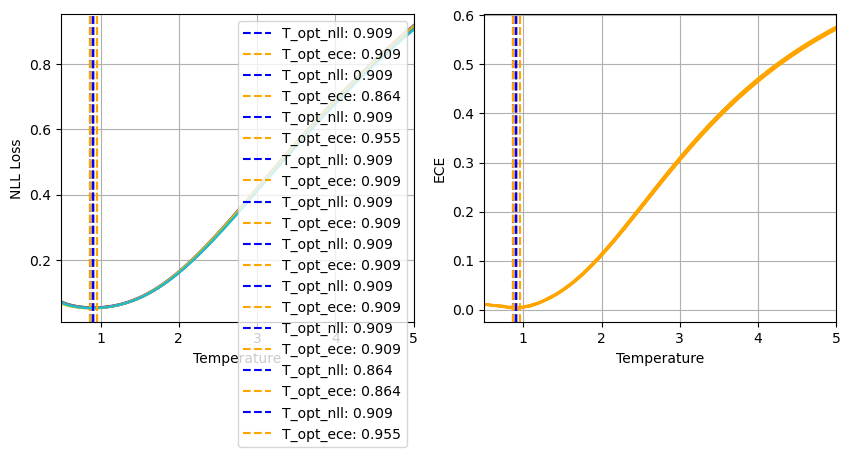

In [13]:
Ts = []
plt.figure(figsize=(10,4))
for i in range(len(out_dict["eval"]["logits"])):
    T_nll,T_ece = mu.optimize_temp_scaling(out_dict["eval"]["logits"][i].numpy(), out_dict["eval"]["gts"].numpy(), do_plot=True, bounds=(0.5,5))
    Ts.append((T_nll, T_ece))
    print(f"Model {i} T_nll: {T_nll:.4f}, T_ece: {T_ece:.4f}")

print("Mean T_nll:", np.mean([t[0] for t in Ts]))
print("Mean T_ece:", np.mean([t[1] for t in Ts]))

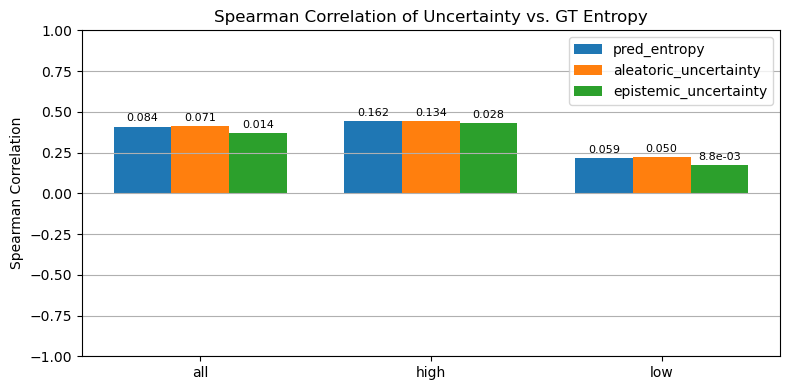

In [10]:
mu.ambiguity_stats(out_dict, au_factor=1.0, do_plot=True); 

## plot stats from big training

In [57]:
import pandas as pd
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves"

df = pd.DataFrame(columns=["unc_cfg","model_cfg","train_acc","test_acc","params",
                           'ece', 'ece_optnll', 'ece_optece', 'nll', 'nll_optnll', 'nll_optece', 'T_opt_nll', 'T_opt_ece',
                            "EU_auc", "AU_auc", "TU_auc", "EU_iid", "EU_ood", "AU_iid", "AU_ood", "TU_iid", "TU_ood",
                            "TU_rankcorr", "EU_rankcorr", "AU_rankcorr",
                             "mean_AU", "mean_EU", "mean_TU",
                            "ens_test_acc", "ens_test_acc_optnll", "ens_test_acc_optece"
    ])

for filename in os.listdir(p):
    if filename.endswith(".pth"):
        file_path = os.path.join(p, filename)
        data = torch.load(file_path, weights_only=False)
        params = sum([v.numel() for v in data["checkpoints"][0].values()])
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        value_dict = {"unc_cfg": unc_cfg, 
                    "model_cfg": model_cfg, 
                    "train_acc": sum([data["final_acc"][i]["train_acc"] for i in range(len(data["final_acc"]))]) / len(data["final_acc"]),
                    "test_acc": sum([data["final_acc"][i]["test_acc"] for i in range(len(data["final_acc"]))]) / len(data["final_acc"]),
                    "params": params,
                    "EU_auc": data["unc_stats"]["ood_stats"]["epistemic_uncertainty"]["auc"],
                    "AU_auc": data["unc_stats"]["ood_stats"]["aleatoric_uncertainty"]["auc"],
                    "TU_auc": data["unc_stats"]["ood_stats"]["pred_entropy"]["auc"],
                    "EU_iid": data["unc_stats"]["ood_stats"]["epistemic_uncertainty"]["iid_entropy"],
                    "EU_ood": data["unc_stats"]["ood_stats"]["epistemic_uncertainty"]["ood_entropy"],
                    "AU_iid": data["unc_stats"]["ood_stats"]["aleatoric_uncertainty"]["iid_entropy"],
                    "AU_ood": data["unc_stats"]["ood_stats"]["aleatoric_uncertainty"]["ood_entropy"],
                    "TU_iid": data["unc_stats"]["ood_stats"]["pred_entropy"]["iid_entropy"],
                    "TU_ood": data["unc_stats"]["ood_stats"]["pred_entropy"]["ood_entropy"],
                    "TU_rankcorr": data["unc_stats"]["amb_stats"]["pred_entropy"]["spearman_all"],
                    "EU_rankcorr": data["unc_stats"]["amb_stats"]["epistemic_uncertainty"]["spearman_all"],
                    "AU_rankcorr": data["unc_stats"]["amb_stats"]["aleatoric_uncertainty"]["spearman_all"],
                    "mean_AU": data["unc_stats"]["amb_stats"]["pred_entropy"]["mean_entropies"]["all"],
                    "mean_EU": data["unc_stats"]["amb_stats"]["epistemic_uncertainty"]["mean_entropies"]["all"],
                    "mean_TU": data["unc_stats"]["amb_stats"]["aleatoric_uncertainty"]["mean_entropies"]["all"],
                    "ens_test_acc": 0.0,
                    "ens_test_acc_optnll": 0.0,
                    "ens_test_acc_optece": 0.0,
                    }
        for k,v in data["unc_stats"]["calib_stats"].items():
            value_dict[k] = v
        ensemble_pred = data["unc_stats"]["eval"]["probs"].mean(0).argmax(1)
        gts = data["unc_stats"]["eval"]["gts"]
        if data["uncertainty_setup"]["ignore_digits"] == [2,3,5]:
            mask = ~np.isin(gts, [2,3,5])
        else:
            mask = slice(None)
        value_list = [value_dict[col] for col in df.columns]
        df.loc[len(df)] = value_list
print(f"Found {len(df)} models")

Found 91 models


In [10]:
print(data["unc_stats"]["calib_stats"].keys())
print(data["unc_stats"]["amb_stats"]["pred_entropy"]["mean_entropies"].keys())
print(data["unc_stats"]["ood_stats"]["pred_entropy"].keys())


dict_keys(['ece', 'ece_optnll', 'ece_optece', 'nll', 'nll_optnll', 'nll_optece', 'T_opt_nll', 'T_opt_ece', 'ece_optece_eq', 'ece_eq', 'ece_optnll_eq'])
dict_keys(['gt', 'all', 'high', 'low'])
dict_keys(['auc', 'ood_entropy', 'iid_entropy'])


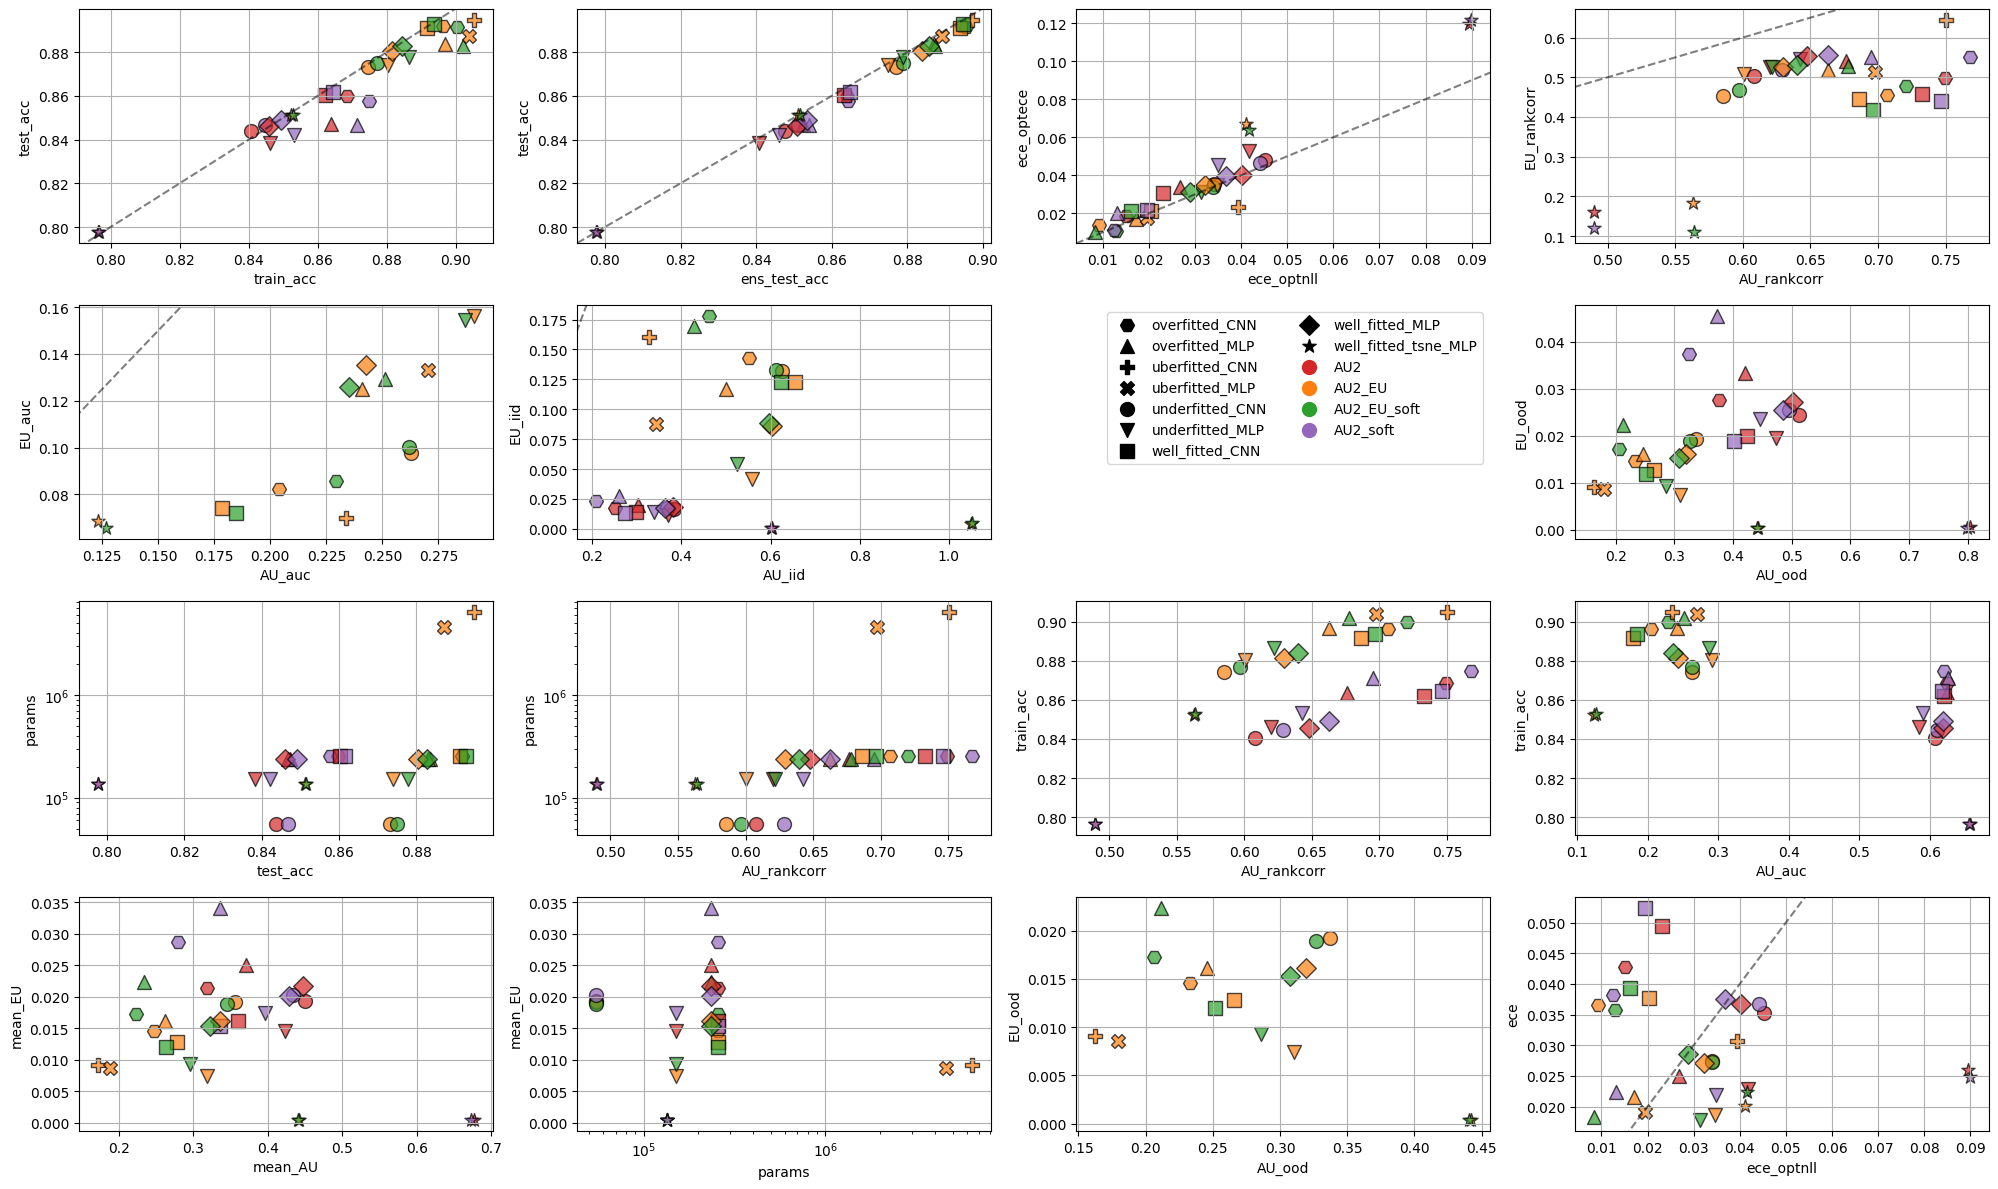

In [60]:
default_options = {"logx": False, "logy": False, "add_x=y": False, "only_EU_cfg": False, "only_AU_cfg": False, "is_legend": False}
scatters = [["train_acc","test_acc", {"add_x=y": True}],    
            ["ens_test_acc","test_acc", {"add_x=y": True}],
            ["ece_optnll","ece_optece", {"add_x=y": True}],
            ["AU_rankcorr","EU_rankcorr", {"add_x=y": True}],
            ["AU_auc","EU_auc", {"add_x=y": True, "only_EU_cfg": True}],
            ["AU_iid","EU_iid", {"add_x=y": True}],
            ["","", {"is_legend": True}],
            ["AU_ood","EU_ood", {"logy": 0, "logx": 0, "only_EU_cfg": False,"add_x=y": True}],
            ["test_acc","params", {"logy": True}],
            ["AU_rankcorr","params", {"logy": True, "only_AU_cfg": True}],
            ["AU_rankcorr","train_acc", {"only_AU_cfg": True}],
            ["AU_auc","train_acc", {"only_AU_cfg": True}],
            ["mean_AU","mean_EU", {"add_x=y": True}],
            ["params","mean_EU", {"logx": True}],
            ["AU_ood","EU_ood", {"logy": False, "logx": False, "only_EU_cfg": True,"add_x=y": True}],
            ["ece_optnll","ece", {"add_x=y": True}],
            ]

include_unc_cfgs = [cfg for cfg in uq_unc_cfgs if "AU2" in cfg]
include_model_cfgs = uq_model_cfgs  #use all models


uq_unc_cfgs = sorted(df["unc_cfg"].unique().tolist())
uq_model_cfgs = sorted(df["model_cfg"].unique().tolist())
symbols = ['H', '^', "P","X", 'o', 'v', 's', 'D', '*']
cols2 = ["#006d77",  # deep teal
    "#daa520",  # goldenrod
    "#f08080",  # light coral
    "#4682b4",  # steel blue
    "#ba55d3",  # medium orchid
    "#2e8b57"  # sea green
]

cols = ["C3", "C1", "C2", "C4", "C0", "C5", "C6", "C7", "C8", "C9"]+cols2
subplots = (4,4)
assert len(scatters) <= subplots[0]*subplots[1], "Too many subplots for grid, add more rows/cols"
fig, axs = plt.subplots(subplots[0], subplots[1], figsize=(5*subplots[1],3*subplots[0]))
for i,(x_key,y_key,options) in enumerate(scatters):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    if options.get("is_legend", default_options["is_legend"]):
        handles = []
        for j,model in enumerate(include_model_cfgs):
            handles.append(ax.scatter([], [], color='k', marker=symbols[j], s=100, label=model))
        for k,unc in enumerate(include_unc_cfgs):
            handles.append(ax.scatter([], [], color=cols[k], marker='o', s=100, label=unc))
        ax.legend(handles=handles, ncol=2)
        ax.axis('off')
        continue

    for j,model in enumerate(include_model_cfgs):
        for k,unc in enumerate(include_unc_cfgs):
            if options.get("only_EU_cfg", default_options["only_EU_cfg"]) and "EU" not in unc:
                continue
            if options.get("only_AU_cfg", default_options["only_AU_cfg"]) and "AU" not in unc:
                continue
            mask = (df["unc_cfg"] == unc) & (df["model_cfg"] == model) & (df["train_acc"] > 0.5)
            if np.sum(mask) == 0:
                continue
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                    color=cols[k], marker=symbols[j], s=100, alpha=0.7, edgecolor='k')
            
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.grid()
    #get current axis bounds
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    l1,l2 = min(x0,y0), max(x1,y1)
    if x_key == y_key:
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(l1,l2), ax.set_ylim(l1,l2)
    if options.get("logx", default_options["logx"]):
        ax.set_xscale('log')
    if options.get("logy", default_options["logy"]):
        ax.set_yscale('log')
    if options.get("add_x=y", default_options["add_x=y"]):
        x1,x2,y1,y2 = ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]
        l1,l2 = min(x1,y1), max(x2,y2)
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(x1,x2), ax.set_ylim(y1,y2)
for i in range(len(scatters), subplots[0]*subplots[1]):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    ax.axis('off')
plt.tight_layout()

In [2]:
 mu.get_seq_models()

{'CNN_c8_aug0': {'model': 'models.CNNDeluxe',
  'data_aug': 0,
  'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3},
  'base_channels': 8},
 'CNN_c8_aug1': {'model': 'models.CNNDeluxe',
  'data_aug': 1,
  'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3},
  'base_channels': 8},
 'CNN_c16_aug0': {'model': 'models.CNNDeluxe',
  'data_aug': 0,
  'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3},
  'base_channels': 16},
 'CNN_c16_aug1': {'model': 'models.CNNDeluxe',
  'data_aug': 1,
  'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3},
  'base_channels': 16},
 'CNN_c32_aug0': {'model': 'models.CNNDeluxe',
  'data_aug': 0,
  'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3},
  'base_channels': 32},
 'CNN_c32_aug1': {'model': 'models.CNNDeluxe',
  'data_aug': 1,
  'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3},
  'base_channels': 32},
 'CNN_c6

In [2]:
list(mu.get_seq_models().keys())

['CNN_c4_aug0',
 'CNN_c4_aug1',
 'CNN_c8_aug0',
 'CNN_c8_aug1',
 'CNN_c16_aug0',
 'CNN_c16_aug1',
 'CNN_c32_aug0',
 'CNN_c32_aug1',
 'CNN_c64_aug0',
 'CNN_c64_aug1',
 'MLP_c32_aug0',
 'MLP_c32_aug1',
 'MLP_c64_aug0',
 'MLP_c64_aug1',
 'MLP_c128_aug0',
 'MLP_c128_aug1',
 'MLP_c256_aug0',
 'MLP_c256_aug1',
 'MLP_c512_aug0',
 'MLP_c512_aug1',
 'CNN_d1_aug0',
 'CNN_d1_aug1',
 'CNN_d2_aug0',
 'CNN_d2_aug1',
 'CNN_d4_aug0',
 'CNN_d4_aug1',
 'CNN_d8_aug0',
 'CNN_d8_aug1',
 'CNN_d16_aug0',
 'CNN_d16_aug1',
 'MLP_d2_aug0',
 'MLP_d2_aug1',
 'MLP_d4_aug0',
 'MLP_d4_aug1',
 'MLP_d8_aug0',
 'MLP_d8_aug1',
 'MLP_d16_aug0',
 'MLP_d16_aug1',
 'MLP_d32_aug0',
 'MLP_d32_aug1',
 'CNN_aug0',
 'MLP_aug0',
 'CNN_aug0.25',
 'MLP_aug0.25',
 'CNN_aug0.5',
 'MLP_aug0.5',
 'CNN_aug0.75',
 'MLP_aug0.75',
 'CNN_aug1',
 'MLP_aug1',
 'CNN_e10',
 'MLP_e10',
 'CNN_e20',
 'MLP_e20',
 'CNN_e30',
 'MLP_e30',
 'CNN_e40',
 'MLP_e40',
 'CNN_e50',
 'MLP_e50']

In [13]:
params_dict = {}
for k,v in mu.get_seq_models().items():
    model = mu.model_from_cfg(v)
    params_dict[k] = model.num_params()
    print(k,"model")
params_dict

{'model': 'models.CNNDeluxe', 'data_aug': 0, 'epochs': 20, 'model_args': {'base_channels': 4, 'num_blocks': 2, 'num_downsamples': 3}}
CNN_c4_aug0 model
{'model': 'models.CNNDeluxe', 'data_aug': 1, 'epochs': 20, 'model_args': {'base_channels': 4, 'num_blocks': 2, 'num_downsamples': 3}}
CNN_c4_aug1 model
{'model': 'models.CNNDeluxe', 'data_aug': 0, 'epochs': 20, 'model_args': {'base_channels': 8, 'num_blocks': 2, 'num_downsamples': 3}}
CNN_c8_aug0 model
{'model': 'models.CNNDeluxe', 'data_aug': 1, 'epochs': 20, 'model_args': {'base_channels': 8, 'num_blocks': 2, 'num_downsamples': 3}}
CNN_c8_aug1 model
{'model': 'models.CNNDeluxe', 'data_aug': 0, 'epochs': 20, 'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3}}
CNN_c16_aug0 model
{'model': 'models.CNNDeluxe', 'data_aug': 1, 'epochs': 20, 'model_args': {'base_channels': 16, 'num_blocks': 2, 'num_downsamples': 3}}
CNN_c16_aug1 model
{'model': 'models.CNNDeluxe', 'data_aug': 0, 'epochs': 20, 'model_args': {'base_chan

{'CNN_c4_aug0': 16600,
 'CNN_c4_aug1': 16600,
 'CNN_c8_aug0': 64626,
 'CNN_c8_aug1': 64626,
 'CNN_c16_aug0': 255128,
 'CNN_c16_aug1': 255128,
 'CNN_c32_aug0': 1013926,
 'CNN_c32_aug1': 1013926,
 'CNN_c64_aug0': 4042562,
 'CNN_c64_aug1': 4042562,
 'MLP_c32_aug0': 34218,
 'MLP_c32_aug1': 34218,
 'MLP_c64_aug0': 84810,
 'MLP_c64_aug1': 84810,
 'MLP_c128_aug0': 235146,
 'MLP_c128_aug1': 235146,
 'MLP_c256_aug0': 732426,
 'MLP_c256_aug1': 732426,
 'MLP_c512_aug0': 2513418,
 'MLP_c512_aug1': 2513418,
 'CNN_d1_aug0': 180473,
 'CNN_d1_aug1': 180473,
 'CNN_d2_aug0': 255128,
 'CNN_d2_aug1': 255128,
 'CNN_d4_aug0': 404438,
 'CNN_d4_aug1': 404438,
 'CNN_d8_aug0': 703058,
 'CNN_d8_aug1': 703058,
 'CNN_d16_aug0': 1300298,
 'CNN_d16_aug1': 1300298,
 'MLP_d2_aug0': 168586,
 'MLP_d2_aug1': 168586,
 'MLP_d4_aug0': 235146,
 'MLP_d4_aug1': 235146,
 'MLP_d8_aug0': 368266,
 'MLP_d8_aug1': 368266,
 'MLP_d16_aug0': 634506,
 'MLP_d16_aug1': 634506,
 'MLP_d32_aug0': 1166986,
 'MLP_d32_aug1': 1166986,
 'CNN_aug0

In [15]:
sum(list(params_dict.values()))

86539560

In [ ]:
#sort df by ens_test_acc and show train_acc, test_acc, ens_test_acc and model_cfg, unc_cfg
df_sorted = df.sort_values(by="ens_test_acc", ascending=False)
print(df_sorted[["model_cfg","unc_cfg","train_acc","test_acc","ens_test_acc"]].to_string(index=False))

           model_cfg     unc_cfg      train_acc       test_acc   ens_test_acc
     well_fitted_CNN          EU       0.996627       0.995259        0.99717
      uberfitted_CNN          EU            1.0       0.995542       0.996745
     well_fitted_CNN     AU.3_EU       0.995324       0.994962       0.996603
     well_fitted_CNN       NoUnc       0.996947        0.99501         0.9963
      uberfitted_CNN       NoUnc            1.0        0.99532         0.9963
     well_fitted_CNN        AU.3        0.99499        0.99422         0.9959
      uberfitted_CNN     AU.3_EU        0.99964       0.995443       0.995896
      overfitted_CNN          EU       0.999807       0.993759       0.995754
      overfitted_CNN     AU.3_EU       0.997388       0.993433       0.995471
      overfitted_CNN       NoUnc        0.99995        0.99261         0.9952
      uberfitted_CNN        AU.3        0.99947        0.99373          0.994
      overfitted_CNN        AU.3       0.996633        0.99074  

In [2]:
unc_cfg = "AU"
model_cfg = "uberfitted_CNN"

data = torch.load(os.path.join(p, f"{unc_cfg}__{model_cfg}.pth"), weights_only=False)

data = torch.load(file_path, weights_only=False)

mu.plot_voronoi(data["unc_stats"], title=f"{unc_cfg}, {model_cfg}",vmax=None)

NameError: name 'p' is not defined

## inspect big training results SEQ

In [3]:
import pandas as pd
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves"

df = pd.DataFrame(columns=["uncertainty","model","train_acc","test_acc","params"])

model_matches = ["MLP_", "CNN_"]
unc_matches_eq = ["AU2_EU"]

for filename in os.listdir(p):
    if filename.endswith(".pth"):
        file_path = os.path.join(p, filename)
        data = torch.load(file_path, weights_only=False)
        num_params = sum([v.numel() for v in data["checkpoints"][0].values()])
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        n = len(data["checkpoints"])
        if not any([model_cfg.startswith(m) for m in model_matches]):
            continue
        if not any([m == unc_cfg for m in unc_matches_eq]):
            continue
        values = [unc_cfg,model_cfg, 
                [float(data["final_acc"][i]["train_acc"]) for i in range(n)], 
                [float(data["final_acc"][i]["test_acc"]) for i in range(n)], 
                num_params]
        df.loc[len(df)] = values
print(f"Found {len(df)} models")

Found 60 models


In [ ]:
seq_types = {"channels_aug": "[MODEL]_c[CHANNELS]_aug1",
             "channels": "[MODEL]_c[CHANNELS]_aug0",
             "depth_aug": "[MODEL]_d[DEPTH]_aug1",
             "depth": "[MODEL]_d[DEPTH]_aug0",
             "aug": "[MODEL]_aug[AUG]",
             "epochs": "[MODEL]_e[EPOCHS]",}

seq_types_match = {"channels_aug": lambda name: name.split("_")[1].startswith("c") and name.endswith("_aug1"),
                    "channels": lambda name: name.split("_")[1].startswith("c") and name.endswith("_aug0"),
                    "depth_aug": lambda name: name.split("_")[1].startswith("d") and name.endswith("_aug1"),
                    "depth": lambda name: name.split("_")[1].startswith("d") and name.endswith("_aug0"),
                    "aug": lambda name: name.split("_")[1].startswith("aug"),
                    "epochs": lambda name: name.split("_")[1].startswith("e"),}

model_types = ["CNN", "MLP"]
identifiers = {"d": ("depth",int), "c": ("channels",int), "aug": ("aug",float), "e": ("epochs",int)}
identifiers_inv = {v[0]: (k,v[1]) for k,v in identifiers.items()}

def seq_type_from_name(name):
    """Returns the sequence type from the model name,
    in addition to all the key-value pairs found in the name.
    """
    split_name = name.split("_")
    params = {}
    params["model_type"] = split_name[0]
    assert params["model_type"] in model_types, f"Unknown model type {params['model_type']} in {name}"
    for i,value in enumerate(split_name[1:]):

        #find identifier in value
        match = 0
        for idf, (idf_full, idf_type) in identifiers.items():
            if value.startswith(idf):
                params[idf_full] = idf_type(value[len(idf):])
                match = 1
                if i==0:
                    params["varying_param"] = idf_full
                break
        assert match, f"Unknown identifier in {value} of {name}. Should start with one of {list(identifiers.keys())}"
    #match to a seq_type. 
    for seq_type, match_fn in seq_types_match.items():
        if match_fn(name):
            params["seq_type"] = seq_type
            break
    assert "seq_type" in params, f"Could not match sequence type for {name}"
    return params

# Add all stats to df. Add new columns if needed.
for i, row in df.iterrows():
    params = seq_type_from_name(row["model"])
    for k,v in params.items():
        if k not in df.columns:
            df[k] = None
        df.at[i,k] = v

{'model_type': 'MLP', 'channels': 64, 'varying_param': 'channels', 'aug': 1.0, 'seq_type': 'channels_aug'}


In [7]:
uq_seq_types

['aug', 'channels', 'channels_aug', 'depth', 'depth_aug', 'epochs']

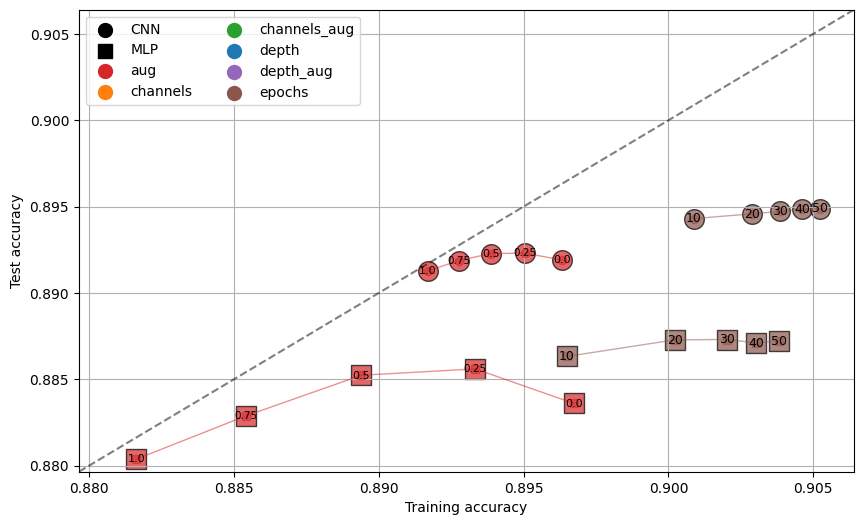

In [8]:
# colors differentiate seq_types
# symbols differentiate model types

uq_model_types = sorted(df["model_type"].unique().tolist())
uq_seq_types = sorted(df["seq_type"].unique().tolist())

#only_show_seq_type = uq_seq_types
only_show_seq_type = ["aug","epochs"]

add_text = True
show_means = True
connect_means = True

symbols = ["o", "s"]
cols = ["C3", "C1", "C2", "C0", "C4", "C5"]
assert len(cols) >= len(uq_seq_types), f"Only {len(cols)} colors for {len(uq_seq_types)} uncertainty types"
assert len(symbols) >= len(uq_model_types), f"Only {len(symbols)} symbols for {len(uq_model_types)} model types"
plt.figure(figsize=(10,6))
for i,mt in enumerate(uq_model_types):
    for j,st in enumerate(uq_seq_types):
        if st not in only_show_seq_type:
            continue
        mask = (df["model_type"] == mt) & (df["seq_type"] == st)
        if np.sum(mask) == 0:
            continue
        sub_df = df[mask]
        assert len(set(sub_df["varying_param"])) == 1, f"Multiple varying params in {mt}, {st}. Found: {set(sub_df['varying_param'])}"

        # extract #[varying_param]x#[num_models] arrays for train_acc and test_acc
        train_accs = np.array(sub_df["train_acc"].tolist())
        test_accs = np.array(sub_df["test_acc"].tolist())
        param_name = sub_df["varying_param"].iloc[0]
        #expand to same size as train_accs/test_accs
        param_values = np.array(sub_df[param_name].tolist())[:,None].repeat(train_accs.shape[1], axis=1)
        
        if show_means:
            train_accs = train_accs.mean(axis=1)
            test_accs = test_accs.mean(axis=1)
            param_values = param_values.mean(axis=1)
            #sort by param_values
            sort_idx = np.argsort(param_values)
            train_accs = train_accs[sort_idx]
            test_accs = test_accs[sort_idx]
            param_values = param_values[sort_idx]
            if connect_means:
                #connect means with a line
                plt.plot(train_accs, test_accs, color=cols[j], marker=symbols[i], alpha=0.5, linewidth=1)
        plt.scatter(train_accs.flatten(), test_accs.flatten(),
                    color=cols[j], marker=symbols[i], s=200 if show_means else 100, alpha=0.7, edgecolor='k'
                )
        if add_text:
            # add param value as text in the center of each point
            param_values = param_values.astype(identifiers_inv[param_name][1])
            for k in range(len(train_accs.flatten())):
                s = str(param_values.flatten()[k])
                modif = 0.5+0.5/len(s)
                plt.text(train_accs.flatten()[k], test_accs.flatten()[k], s,
                        color='k', fontsize=12*modif, ha='center', va='center')
                

for j,model in enumerate(uq_model_types):
    plt.scatter([], [], color='k', marker=symbols[j], s=100, label=model)
for i,unc in enumerate(uq_seq_types):
    plt.scatter([], [], color=cols[i], marker='o', s=100, label=unc)
plt.xlabel("Training accuracy")
plt.ylabel("Test accuracy")
plt.legend(ncols=2)
#get current axis bounds
ax = plt.gca()
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
l1,l2 = min(x0,y0), max(x1,y1)
plt.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
plt.xlim(l1,l2), plt.ylim(l1,l2)
plt.grid()



In [18]:
list(mu.get_seq_models_heavy().keys())

['CNN_aug0_H',
 'MLP_aug0_H',
 'CNN_aug0.005_H',
 'MLP_aug0.005_H',
 'CNN_aug0.01_H',
 'MLP_aug0.01_H',
 'CNN_aug0.02_H',
 'MLP_aug0.02_H',
 'CNN_aug0.04_H',
 'MLP_aug0.04_H',
 'CNN_aug0.08_H',
 'MLP_aug0.08_H',
 'CNN_aug0.16_H',
 'MLP_aug0.16_H',
 'CNN_aug0.32_H',
 'MLP_aug0.32_H',
 'CNN_aug0.64_H',
 'MLP_aug0.64_H',
 'CNN_aug1_H',
 'MLP_aug1_H',
 'CNN_aug1.28_H',
 'MLP_aug1.28_H']